In [1]:
from polybinder.system import System, Initializer
from polybinder.simulate import Simulation
import mbuild as mb
import hoomd
from mbuild.formats.hoomd_forcefield import to_hoomdsnapshot
import numpy as np

import os
from datetime import datetime
import rowan

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
## set parameters
dt = 0.0003
tau_kT = 10
kT = 1.1

In [4]:
system_params = System(density=0.01,
                    molecule="PPS",
                    polymer_lengths=1,
                    n_compounds=2,
                    para_weight=1.0,
                   )

In [5]:
PPS_system_saved = Initializer(system=system_params,
                        system_type='stack',
                        remove_hydrogens=True,
                        n_rigid_beads=system_params.polymer_lengths[0] * system_params.n_compounds[0],
                        rigid_bead_len=7,
                        rigid_bead_names=['R1', 'R2'],
                        separation=0.6,
                        forcefield="opls",
                        save_parmed=False
                              )

Removing hydrogens and adjusting heavy atoms
---------------------------------------------------------------
make rigid snap...


In [6]:
PPS_system_saved.snapshot.particles.typeid

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint32)

In [7]:
log_dir = "/home/marjanalbooyeh/logs/pps_two_synthesized/"
now = datetime.now()
log_path = os.path.join(log_dir, now.strftime("%Y-%m-%d-%H:%M:%S")) + '/'


if not os.path.exists(log_path):
    os.mkdir(log_path)

In [8]:
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
snapshot, forcefields, refs = create_hoomd_forcefield(
            structure=PPS_system_saved.system,
            r_cut=2.5,
            auto_scale=True,
            init_snap=PPS_system_saved.snapshot
        )

Processing LJ and QQ
No charged groups found, ignoring electrostatics
Processing 1-4 interactions, adjusting neighborlist exclusions
Processing harmonic bonds
Processing harmonic angles
Processing RB torsions


In [10]:
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device=device, seed=1)

In [11]:
from cmeutils.geometry import moit
def _update_rigid_snapshot(snapshot, rigid_idx):
    rigid = hoomd.md.constrain.Rigid()
    for i, inds in enumerate(rigid_idx):
        total_mass = np.sum(snapshot.particles.mass[inds])
        com = (
                np.sum(
                    snapshot.particles.position[inds]
                    * snapshot.particles.mass[inds, np.newaxis],
                    axis=0,
                )
                / total_mass
        )
        snapshot.particles.position[i] = com
        snapshot.particles.body[i] = i
        snapshot.particles.body[inds] = i * np.ones_like(inds)
        snapshot.particles.mass[i] = np.sum(snapshot.particles.mass[inds])
        snapshot.particles.moment_inertia[i] = moit(
            snapshot.particles.position[inds],
            snapshot.particles.mass[inds],
            center=com,
        )
        r_pos = snapshot.particles.position[i]
        c_pos = snapshot.particles.position[inds]
        c_pos -= r_pos
        c_pos = [tuple(j) for j in c_pos]
        c_types = [
            snapshot.particles.types[j] for j in snapshot.particles.typeid[inds]
        ]
        c_orient = [tuple(j) for j in snapshot.particles.orientation[inds]]
        c_charge = [j for j in snapshot.particles.charge[inds]]
        c_diam = [j for j in snapshot.particles.diameter[inds]]
        body_name = snapshot.particles.types[snapshot.particles.typeid[i]]

        rigid.body[snapshot.particles.types[snapshot.particles.typeid[i]]] = {
            "constituent_types": c_types,
            "positions": c_pos,
            "charges": c_charge,
            "orientations": c_orient,
            "diameters": c_diam,
        }
    return rigid

In [12]:
rigid = _update_rigid_snapshot(snapshot, PPS_system_saved.rigid_idx)

In [13]:
PPS_system_saved.rigid_idx

[array([2, 3, 4, 5, 6, 7, 8]), array([ 9, 10, 11, 12, 13, 14, 15])]

In [79]:
snapshot.particles.types

['R1', 'R2', 'opls_145', 'opls_200']

In [76]:
dict(rigid.body)

{'R2': _HOOMDDict{'constituent_types': ['opls_145', 'opls_145', 'opls_145', 'opls_145', 'opls_200', 'opls_145', 'opls_145'], 'positions': [(0.0879160722266048, 0.0041908360503873174, -0.6451031299739882), (0.049560538770362816, -0.33327581406963186, -0.45650812259302365), (-0.002931098766756124, -0.3360288235454815, -0.0714882984479108), (-0.01703860126832546, -0.0008154406032485268, 0.12540812929974135), (-0.08420447867072167, -0.004032842804164013, 0.6180177805639331), (0.021315518819713608, 0.33692902438634037, -0.06382637578638703), (0.07377580316745447, 0.3391823263574672, -0.4488170618772007)], 'charges': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'orientations': [(1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0)], 'diameters': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}}

In [14]:
for i, force in enumerate(forcefields):
    if isinstance(force, hoomd.md.pair.LJ):
        for t in snapshot.particles.types:
            for r in ['R1', 'R2']:
                force.params[(r, t)] = dict(epsilon=0, sigma=0)
                force.r_cut[(r, t)] = 0
    if isinstance(force, hoomd.md.special_pair.LJ):
        for k in force.params.keys():
            force.params[k] = dict(epsilon=0., sigma=0.)
    if isinstance(force, hoomd.md.bond.Harmonic):
        for k in force.params.keys():
            force.params[k] = dict(k=0, r0=0)
    if isinstance(force, hoomd.md.angle.Harmonic):
        for k in force.params.keys():
            force.params[k] = dict(t0=0, k=0)
    if isinstance(force, hoomd.md.dihedral.Harmonic):
        for k in force.params.keys():
            force.params[k] = dict(k1=0, k2=0, k3=0, k4=0)

In [15]:
sim.create_state_from_snapshot(snapshot)

In [16]:
rigid_snap = sim.state.get_snapshot()
rigid_snap.particles.typeid

array([1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2], dtype=uint32)

In [17]:
rigid_filter = hoomd.filter.Rigid(("center", "free"))
R1_filter = hoomd.filter.Tags([0])
_filter= hoomd.filter.SetDifference(hoomd.filter.All(), R1_filter)

integrator = hoomd.md.Integrator(dt=dt, integrate_rotational_dof=True)
integrator.forces = forcefields
integrator.rigid = rigid
integrator_method = hoomd.md.methods.NVT(
                    filter=_filter, kT=kT, tau=tau_kT)
integrator.methods=[integrator_method]
sim.operations.integrator = integrator
sim.state.thermalize_particle_momenta(filter=_filter, kT=kT)

thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)
sim.run(0)

*Warning*: angle.harmonic: specified K <= 0
*Warning*: angle.harmonic: specified t_0 <= 0
*Warning*: angle.harmonic: specified K <= 0
*Warning*: angle.harmonic: specified t_0 <= 0


In [18]:
logger = hoomd.logging.Logger()
logger.add(thermodynamic_properties, quantities=["potential_energy","kinetic_energy", "kinetic_temperature", "pressure"])
logger.add(sim.operations.integrator.forces[0], quantities=["energy"]) # LJ 
gsd_writer = hoomd.write.GSD(
    filename=log_path + '/'+ "pps_synthesized_original.gsd",
    trigger=hoomd.trigger.Periodic(
        period=int(1), phase=0
    ),
    filter=hoomd.filter.All(),
    mode="wb",
    dynamic=["momentum"],
    
)
sim.operations.writers.append(gsd_writer)
gsd_writer.log = logger

In [19]:
dynamic_particles_idx = [1, 9, 10, 11, 12, 13, 14, 15]

### toy orientations

## create grid positions and orientations

In [20]:
snap = sim.state.get_snapshot()
com_pos_1 = snap.particles.position[0]
com_pos_2 = snap.particles.position[1]

grid_slice = 20
radius_increament = 0.05
radius_iterations = 30
init_radius = np.abs(com_pos_1[0] - com_pos_2[0])

# dt = (2 * np.pi)/grid_slice
dt = (np.pi)/grid_slice
grid_positions = []
for j in range(radius_iterations):
    radius = init_radius + j*radius_increament
    for i in range(grid_slice):
        grid_positions.append((com_pos_1[0] + (radius* np.cos(i*dt)), com_pos_1[1] +  (radius* np.sin(i*dt))))
        
orientation_num = 100
rowan_grid_orientations= rowan.random.rand(orientation_num)

In [21]:
len(grid_positions)

600

In [22]:
sim.operations.integrator.forces[0].energy

-1.9130046071354307

In [23]:
positions = []
orientations= []
forces = []
torques = []
energies = []

for q in rowan_grid_orientations:
    for (x, y) in grid_positions:
        with sim.state.cpu_local_snapshot as data:
            idx = data.particles.rtag[1]
            data.particles.position[idx] = (x, y, com_pos_1[2])
            data.particles.orientation[idx] = q
        sim.run(0, write_at_start=True)
        energies.append(sim.operations.integrator.forces[0].energy)
        with sim.state.cpu_local_snapshot as data:
            com_idx = data.particles.rtag[[0, 1]]
            positions.append(data.particles.position[com_idx])
            orientations.append(data.particles.orientation[com_idx])
            forces.append(data.particles.net_force[com_idx])
            torques.append(data.particles.net_torque[com_idx])
        sim.run(1)

### save gsd

In [24]:
import gsd.hoomd

In [25]:
traj = gsd.hoomd.open(log_path + '/'+ "pps_synthesized_original.gsd", "rb")
indices = (np.arange(int(len(traj)/2)) * 2).tolist()

In [26]:
new_traj =  gsd.hoomd.open(name= log_path + '/pps_synthesized_trimmed.gsd', mode='wb')
new_traj.extend(traj[i] for i in indices)
new_traj.close()

### plot energies and forces

In [27]:
import matplotlib.pyplot as plt
import numpy as np

(-5.0, 3.0)

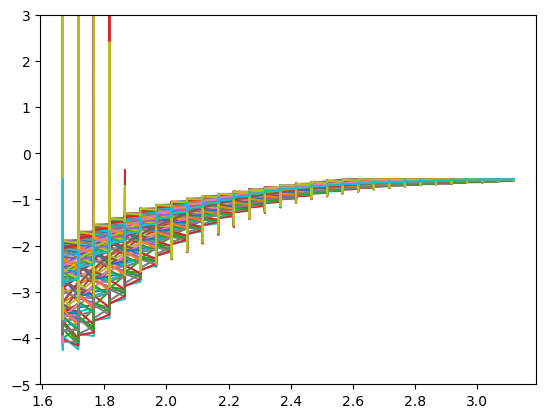

In [28]:
for i in range(len(rowan_grid_orientations)):
    pos_arr = np.asarray(positions[i* len(grid_positions):(i+1)*len(grid_positions)])
    r = np.linalg.norm(pos_arr[:, 0, :]-pos_arr[:, 1, :], axis=1)
    plt.plot(r, energies[i* len(grid_positions):(i+1)*len(grid_positions)])

plt.ylim(-5, 3)

In [219]:
max(energies)

84.16371344260249

(-4.0, 1.0)

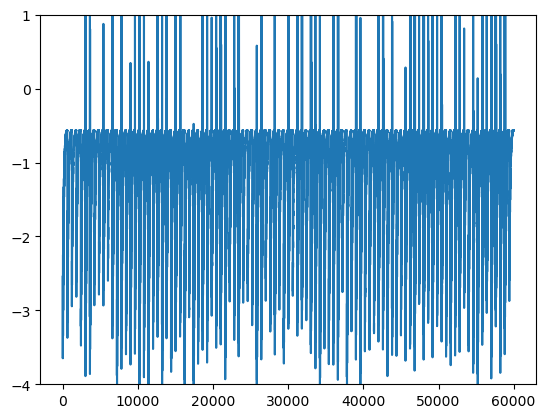

In [218]:
plt.plot(energies)
plt.ylim((-4, 1))

### save dataset

In [34]:
positions = np.asarray(positions)
orientations = np.asarray(orientations)
forces = np.asarray(forces)
torques = np.asarray(torques)

#### distances and rel. positions

In [74]:
rel_positions = np.zeros((positions.shape[0], positions.shape[1], positions.shape[2]+1))
rel_positions[:, 0, :3] = positions[:, 0, :3] - positions[:, 1, :3]
rel_positions[:, 1, :3] = positions[:, 1, :3] - positions[:, 0, :3]
rel_positions[:, :, 3] = np.linalg.norm(rel_positions[:, :, :3], axis=2)

#### orientation riemann_log_map and sym_intrinsic_distance

In [83]:
import rowan

In [81]:
rel_orientations = np.zeros((orientations.shape[0], orientations.shape[1], orientations.shape[2]+1))
rel_orientations[:, 0, :4] = rowan.geometry.riemann_log_map(orientations[:, 0,:], orientations[:, 1, :])
rel_orientations[:, 1, :4] = rowan.geometry.riemann_log_map(orientations[:, 1, :], orientations[:, 0, :])
rel_orientations[:, 0, 4] = rowan.geometry.sym_intrinsic_distance(orientations[:, 0, :], orientations[:, 1, :])
rel_orientations[:, 1, 4] = rowan.geometry.sym_intrinsic_distance(orientations[:, 1, :], orientations[:, 0, :])

In [201]:
forces.shape

(60000, 2, 3)

In [202]:
rel_orientations.shape

(60000, 2, 5)

In [204]:
columns = [
    "position",
    "orientation",
    "net_force",
    "net_torque",
]

import pandas as pd
traj_df = pd.DataFrame(columns=columns)

In [111]:
traj_df["position"] = rel_positions.reshape(rel_positions.shape[0]*rel_positions.shape[1], rel_positions.shape[2]).tolist()
traj_df["orientation"] = rel_orientations.reshape(rel_orientations.shape[0]*rel_orientations.shape[1], rel_orientations.shape[2]).tolist()
traj_df["net_force"] = forces.reshape(forces.shape[0]*forces.shape[1], forces.shape[2]).tolist()
traj_df["net_torque"] = torques.reshape(torques.shape[0]*torques.shape[1], torques.shape[2]).tolist()

In [205]:
traj_df["position"] = rel_positions.tolist()
traj_df["orientation"] = rel_orientations.tolist()
traj_df["net_force"] = forces.tolist()
traj_df["net_torque"] = torques.tolist()

In [206]:
traj_df.to_pickle("/home/marjanalbooyeh/logs/datasets/pps_two_synthesized/raw_data_neighbors.pkl")

### prepare ML model data

In [207]:
traj_df.head()

,position,orientation,net_force,net_torque
0,"[[-1.6666666666666663, 0.0, 0.0, 1.66666666666...","[[0.0, 0.9224391178104391, 0.32560408677396646...","[[7.1532204034117886, 0.22243932363621566, -0....","[[0.07230738220393593, -0.5154495628658031, 0...."
1,"[[-1.6461472343252292, -0.26072410840038474, 0...","[[0.0, 0.9224391178104391, 0.32560408677396646...","[[7.154939239971017, 0.2221260413439498, -0.34...","[[0.07228587889501019, -0.516500998821138, 0.0..."
2,"[[-1.5850941938252556, -0.5150283239582455, 0....","[[0.0, 0.9224391178104391, 0.32560408677396646...","[[5.478712175611795, 1.6881740190876324, -0.35...","[[0.14171650682773196, -0.15249776012939298, 0..."
3,"[[-1.4850108736472796, -0.7566508328992444, 0....","[[0.0, 0.9224391178104391, 0.32560408677396646...","[[1.653045863812842, 1.9430140536765077, -0.75...","[[-0.15598402985892157, 0.637213402326216, 1.4..."
4,"[[-1.3483616572915789, -0.9796420871541217, 0....","[[0.0, 0.9224391178104391, 0.32560408677396646...","[[-2.206691632325201, 0.2124284872351735, -1.2...","[[-0.8264980811815716, 1.269053617242332, 2.22..."


In [208]:
#shuffle order of frames
traj_df = traj_df.sample(frac=1).reset_index(drop=True)

In [209]:
### Split dataset 


test_frac = 0.1
val_frac = 0.1

dataset_len = traj_df.shape[0]
test_len = int(dataset_len * test_frac)
val_len = int(dataset_len * val_frac)


test_df = traj_df.loc[:test_len]

val_df = traj_df.loc[test_len: test_len + val_len]

train_df = traj_df.loc[test_len + val_len:]

In [210]:
target_data_path = "/home/marjanalbooyeh/logs/datasets/pps_two_synthesized/neighbors"
import os
if not os.path.exists(target_data_path):
    os.mkdir(target_data_path)
train_df.to_pickle(target_data_path + 'train.pkl')
val_df.to_pickle(target_data_path + 'val.pkl')
test_df.to_pickle(target_data_path + 'test.pkl')

In [211]:
import torch

In [212]:
pos = torch.from_numpy(np.array(list(traj_df['position']))).type(torch.FloatTensor)

In [124]:
ori = torch.from_numpy(np.array(list(traj_df['orientation']))).type(torch.FloatTensor)

In [143]:
res = torch.stack((pos, ori), dim=1)

In [142]:
pos = torch.cat((pos, torch.zeros(pos.shape[0], 1)), dim=1)

In [213]:
pos.shape

torch.Size([60000, 2, 4])

In [196]:
from torch.utils.data import Dataset, DataLoader
class CustomTrajDataset(Dataset):
    def __init__(self, traj_df, mode="append"):
        positions = torch.from_numpy(np.array(list(traj_df['position']))).type(torch.FloatTensor)
        orientations = torch.from_numpy(np.array(list(traj_df['orientation']))).type(torch.FloatTensor)
        forces = torch.from_numpy(np.array(list(traj_df['net_force']))).type(torch.FloatTensor)
        torques = torch.from_numpy(np.array(list(traj_df['net_torque']))).type(torch.FloatTensor)

        if mode == "append":
            self.input = torch.cat((positions, orientations), 1)
        else:
            positions = torch.cat((positions, torch.zeros(positions.shape[0], 1)), dim=1)
            self.input = torch.stack((positions, orientations), dim=1)
        self.forces = forces
        self.torques = torques
        self.in_dim = self.input.shape[-1]

    def __len__(self):
        return len(self.input)

    def __getitem__(self, i):
        return self.input[i], self.forces[i], self.torques[i]

In [197]:
def _get_data_loader(dataset, batch_size, shuffle=True):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    return dataloader

In [198]:
train_dataset = CustomTrajDataset(train_df)

In [199]:
train_dataloader = _get_data_loader(dataset=train_dataset, batch_size=16, shuffle=True)

In [200]:
train_dataloader.dataset.in_dim

9

In [182]:
import torch.nn as nn
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, n_layers, act_fn="ReLU"):
        super(NN, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.act_fn = act_fn

        self.force_net = nn.Sequential(*self._get_net())
        self.torque_net = nn.Sequential(*self._get_net())

    def _get_act_fn(self):
        act = getattr(nn, self.act_fn)
        return act()

    def _get_net(self):
        layers = [nn.Linear(self.in_dim, self.hidden_dim), self._get_act_fn()]
        for i in range(self.n_layers - 1):
            layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            layers.append(nn.Dropout(p=0.5))
            layers.append(self._get_act_fn())
        layers.append(nn.Linear(self.hidden_dim, self.out_dim))
        return layers

    def forward(self, x):
        return self.force_net(x), self.torque_net(x)

In [183]:
model = NN(in_dim=train_dataloader.dataset.in_dim, hidden_dim=32, out_dim=3, n_layers=1, act_fn="Tanh")

In [189]:
model.to(device)

NN(
  (force_net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
  (torque_net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [184]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [185]:
for (input, target_force, target_torque) in train_dataloader: 
    feature_tensor = input.to(device)
    target_force = target_force.to(device)
    target_torque = target_torque.to(device)
    break

In [186]:
feature_tensor.shape

torch.Size([16, 2, 5])

In [191]:
out = model(feature_tensor)

In [194]:
out[0].shape

torch.Size([16, 2, 3])

In [195]:
target_force.shape

torch.Size([16, 3])